Lane detection
===

In this Notebook we will learn how to detect the lanes on a road.
This is an adaptation of the code present in 01_lane_detection.py, processing a single image.
For a complete description, please read the content of the book.

Import
==
We start importing what we need and initializing a few variables.

In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
from copy import deepcopy

import sys
sys.path.append('../')

from utils import set_save_files, save_dir, ensure_dir, get_save_files
import matplotlib
from matplotlib.pyplot import imshow, figure, plot, clf

perspective_correction = None
perspective_correction_inv = None
perspective_trapezoid = None
warp_size = None
orig_size = None
left_fit_avg = None
right_fit_avg = None
MIN_DETECTIONS = 8
MAX_DETECTIONS = 10

Perspective
==
The first step is computing the values of the variables used for the perspective correction.
We can use these variables to "Warp" the area of the road that we are analyzing, to obtain a "bird's-eye view"

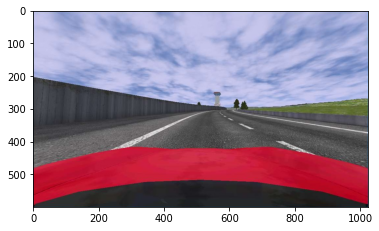

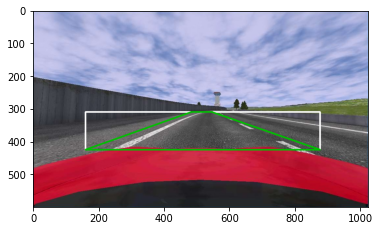

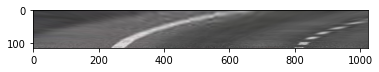

In [2]:
# pt1, pt2, ptr3, and pt4 and four points defining a trapezoid used for the perspective correction
def compute_perspective(width, height, pt1, pt2, pt3, pt4):
    global perspective_trapezoid, perspective_dest

    perspective_trapezoid = [(pt1[0], pt1[1]), (pt2[0], pt2[1]), (pt3[0], pt3[1]), (pt4[0], pt4[1])]
    src = np.float32([pt1, pt2, pt3, pt4])
    # widest side on the trapezoid
    x1 = pt1[0]
    x2 = pt4[0]
    # height of the trapezoid
    y1 = pt1[1]
    y2 = pt2[1]
    h = y1 - y2
    # The destination is a rectangle with the height of the trapezoid and the width of the widest side
    dst = np.float32([[x1, h], [x1, 0], [x2, 0], [x2, h]])
    perspective_dest = [(x1, y1), (x1, y2), (x2, y2), (x2, y1)]

    global perspective_correction, perspective_correction_inv
    global warp_size, orig_size

    perspective_correction = cv2.getPerspectiveTransform(src, dst)
    perspective_correction_inv = cv2.getPerspectiveTransform(dst, src)
    warp_size = (width, h)
    orig_size = (width, height)

def warp(img, filename):
    img_persp = img.copy()

    cv2.line(img_persp, perspective_dest[0], perspective_dest[1], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[1], perspective_dest[2], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[2], perspective_dest[3], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[3], perspective_dest[0], (255, 255, 255), 3)

    cv2.line(img_persp, perspective_trapezoid[0], perspective_trapezoid[1], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[1], perspective_trapezoid[2], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[2], perspective_trapezoid[3], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[3], perspective_trapezoid[0], (0, 192, 0), 3)

    return img_persp, cv2.warpPerspective(img, perspective_correction, warp_size, flags=cv2.INTER_LANCZOS4)

compute_perspective(1024, 600, [160, 425], [484, 310], [546, 310], [877, 425])

filename = "sd2.jpg"
img_bgr = cv2.imread("test_images_sd/" + filename)
imshow(cv2.cvtColor(img_bgr, cv2.COLOR_RGB2BGR))
figure()
img_persp, img_warped = warp(img_bgr, filename)
imshow(cv2.cvtColor(img_persp, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR))

Edge detection
==

We will now apply Scharr, to perform an edge detection on the image of the road.

C:\Users\mario\AppData\Local\Temp\ipykernel_928\3167052425.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(np.float)


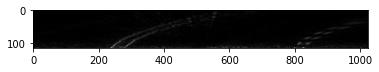

In [3]:
def edge_detection(channel, filename):
    edge_x = cv2.Scharr(channel, cv2.CV_64F, 1, 0)  # Edge detection using the Scharr operator
    edge_x = np.absolute(edge_x)

    return save_dir(np.uint8(255 * edge_x / np.max(edge_x)), "edge_", filename)

img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(np.float)
img_edge = edge_detection(img_warped[:, :, 1], filename)
imshow(cv2.cvtColor(img_edge, cv2.COLOR_RGB2BGR))

Thresholding
==

The next step is applying a threshold, to reduce the noise; to optimize the result, the threshold changes gradually.

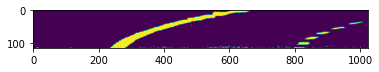

In [4]:
def threshold(channel_threshold, channel_edge, filename):
    # Gradient threshold
    binary = np.zeros_like(channel_edge)
    height = binary.shape[0]

    threshold_up = 15
    threshold_down = 60
    threshold_delta = threshold_down - threshold_up

    for y in range(height):
        binary_line = binary[y, :]
        edge_line = channel_edge[y, :]
        threshold_line = threshold_up + threshold_delta * y / height
        binary_line[edge_line >= threshold_line] = 255

    binary[(channel_threshold >= 140) & (channel_threshold <= 255)] = 255

    binary_threshold = np.zeros_like(channel_threshold)
    binary_threshold[(channel_threshold >= 140) & (channel_threshold <= 255)] = 255

    return binary, binary_threshold

(img_binary_combined, img_binary_solo) = threshold(img_hls[:, :, 1], img_edge, filename)

imshow(img_binary_combined)

Histogram
==
Now we will copute the histogram, to detect the position of the lines.

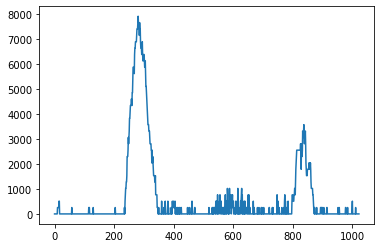

In [5]:
def histogram(img):
    partial_img = img[img.shape[0] * 2 // 3:, :]  # Select the bottom part (one third of the image)
    hist = np.sum(partial_img, axis=0)

    plot(hist)

    return hist

hist = histogram(img_binary_combined)

Lanes
==
We will now detect the lanes using the histogram and the slide window technique.

C:\Users\mario\AppData\Local\Temp\ipykernel_928\392264944.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_height = np.int(img_height / num_windows)
C:\Users\mario\AppData\Local\Temp\ipykernel_928\392264944.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

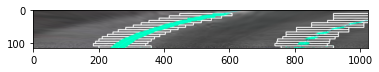

In [6]:
class HistLanes:
    def __init__(self, x_left, x_right, left_confidence, right_confidence):
        self.x_left = x_left
        self.x_right = x_right
        self.left_confidence = left_confidence
        self.right_confidence = right_confidence

def lanes_full_histogram(histogram):
    size = len(histogram)
    max_index_left = np.argmax(histogram[0:size // 2])
    max_index_right = np.argmax(histogram[size // 2:]) + size // 2

    return HistLanes(max_index_left, max_index_right, histogram[max_index_left], histogram[max_index_right])

def moving_average(prev_average, new_value, beta):
    return beta * prev_average + (1 - beta) * new_value if prev_average is not None else new_value

# Single lane line
class Line:
    lane_indexes = None
    # pixel positions
    x = None
    y = None

    # Fit a second order polynomial to each
    fit = None
    # Plotting parameters
    fitx = None

    # Histogram
    hist_x = None


# Data collected during the sliding windows phase
class SlideWindow:
    left = Line()
    right = Line()
    hist = None

    left_avg = None
    right_avg = None

    ploty = None

    def __init__(self, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y):
        self.left.lane_indexes = np.concatenate(left_lane_indexes)
        self.right.lane_indexes = np.concatenate(right_lane_indexes)
        self.left.hist_x = hist.x_left
        self.right.hist_x = hist.x_right
        # Extract left and right positions
        self.left.x = non_zero_x[self.left.lane_indexes]
        self.left.y = non_zero_y[self.left.lane_indexes]
        self.right.x = non_zero_x[self.right.lane_indexes]
        self.right.y = non_zero_y[self.right.lane_indexes]

    def plot_lines(self, img, color_left=(0, 255, 255), color_right=(0, 255, 255)):
        left = []
        right = []
        for i in range(0, len(self.ploty)):
            left.append((self.left.fitx[i], self.ploty[i]))
            right.append((self.right.fitx[i], self.ploty[i]))

        cv2.polylines(img, np.int32([left]), False, color_left)
        cv2.polylines(img, np.int32([right]), False, color_right)

        return img


def fit_slide_window(binary_warped, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y):
    sw = SlideWindow(hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y)

    # y coordinates
    sw.ploty = np.array([float(x) for x in range(binary_warped.shape[0])])

    if len(sw.left.y) == 0:
        return False, sw

    # Fit a second order polynomial to approximate the points
    left_fit = np.polynomial.polynomial.polyfit(sw.left.y, sw.left.x, 2)
    right_fit = np.polynomial.polynomial.polyfit(sw.right.y, sw.right.x, 2)

    global left_fit_avg, right_fit_avg

    left_fit_avg = moving_average(left_fit_avg, left_fit, 0.92)
    right_fit_avg = moving_average(right_fit_avg, right_fit, 0.92)

    # Generate list of x and y values, using the terms of the polynomial
    # x = Ay^2 + By + C;
    sw.left.fitx = left_fit_avg[2] * sw.ploty ** 2 + left_fit_avg[1] * sw.ploty + left_fit_avg[0]
    sw.right.fitx = right_fit_avg[2] * sw.ploty ** 2 + right_fit_avg[1] * sw.ploty + right_fit_avg[0]

    return True, sw

def slide_window(img, binary_warped, hist, num_windows):
    img_height = binary_warped.shape[0]
    window_height = np.int(img_height / num_windows)
    # Indices (e.g. coordinates) of the pixels that are not zero
    non_zero = binary_warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    # Current positions, to be updated while sliding the window; we start with the ones identified with the histogram
    left_x = hist.x_left
    right_x = hist.x_right
    margin = 80
    # Set minimum number of pixels found to recenter window
    min_pixels = 25
    left_lane_indexes = []
    right_lane_indexes = []

    out_img = img.copy()

    for idx_window in range(num_windows):
        # X range where we expect the left lane to land
        win_x_left_min = left_x - margin
        win_x_left_max = left_x + margin
        # X range where we expect the right lane to land
        win_x_right_min = right_x - margin
        win_x_right_max = right_x + margin
        # Y range that we are analyzing
        win_y_top = img_height - idx_window * window_height
        win_y_bottom = win_y_top - window_height

        # Show the windows
        cv2.rectangle(out_img, (win_x_left_min, win_y_bottom), (win_x_left_max, win_y_top), (255, 255, 255), 2)
        cv2.rectangle(out_img, (win_x_right_min, win_y_bottom), (win_x_right_max, win_y_top), (255, 255, 255), 2)

        # Non zero pixels in x and y
        non_zero_left = ((non_zero_y >= win_y_bottom) & (non_zero_y < win_y_top) & (non_zero_x >= win_x_left_min) & (
                non_zero_x < win_x_left_max)).nonzero()[0]
        non_zero_right = ((non_zero_y >= win_y_bottom) & (non_zero_y < win_y_top) & (non_zero_x >= win_x_right_min) & (
                non_zero_x < win_x_right_max)).nonzero()[0]

        left_lane_indexes.append(non_zero_left)
        right_lane_indexes.append(non_zero_right)
        # If you found > min_pixels pixels, recenter next window on the mean position
        if len(non_zero_left) > min_pixels:
            left_x = np.int(np.mean(non_zero_x[non_zero_left]))

        if len(non_zero_right) > min_pixels:
            right_x = np.int(np.mean(non_zero_x[non_zero_right]))

    valid, sw = fit_slide_window(binary_warped, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y)

    if valid :
        out_img[non_zero_y[sw.left.lane_indexes], non_zero_x[sw.left.lane_indexes]] = [0, 255, 192]
        out_img[non_zero_y[sw.right.lane_indexes], non_zero_x[sw.right.lane_indexes]] = [0, 255, 192]
        img_plot = sw.plot_lines(out_img)

        imshow(img_plot)

    return valid, sw

lanes = lanes_full_histogram(hist)

ret, sw = slide_window(img_warped, img_binary_combined, lanes, 15)

Lanes!
==
Finally, we are ready to show the lanes on the original image.

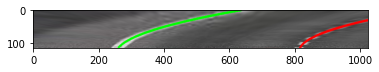

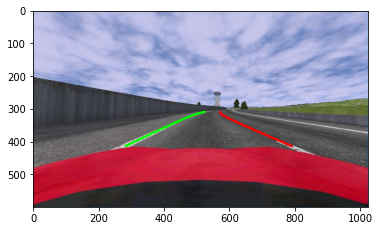

In [7]:
def show_lanes(sw, img_warped, img_orig):
    img = img_warped.copy()

    if sw.left:
        fitx_points_warped = np.float32([np.transpose(np.vstack([sw.left.fitx, sw.ploty]))])
        fitx_points = cv2.perspectiveTransform(fitx_points_warped, perspective_correction_inv)
        left_line_warped = np.int_(fitx_points_warped[0])
        left_line = np.int_(fitx_points[0])
        n = len(left_line)

        for i in range(n - 1):
            cv2.line(img_orig, (left_line[i][0], left_line[i][1]), (left_line[i + 1][0], left_line[i + 1][1]),
                     (0, 255, 0), 5)
            cv2.line(img, (left_line_warped[i][0], left_line_warped[i][1]),
                     (left_line_warped[i + 1][0], left_line_warped[i + 1][1]), (0, 255, 0), 5)

    if sw.right:
        fitx_points_warped = np.float32([np.transpose(np.vstack([sw.right.fitx, sw.ploty]))])
        fitx_points = cv2.perspectiveTransform(fitx_points_warped, perspective_correction_inv)
        right_line_warped = np.int_(fitx_points_warped[0])
        right_line = np.int_(fitx_points[0])

        for i in range(len(right_line) - 1):
            cv2.line(img_orig, (right_line[i][0], right_line[i][1]), (right_line[i + 1][0], right_line[i + 1][1]),
                     (0, 0, 255), 5)
            cv2.line(img, (right_line_warped[i][0], right_line_warped[i][1]),
                     (right_line_warped[i + 1][0], right_line_warped[i + 1][1]), (0, 0, 255), 5)

    return img, img_orig

left_lanes = deepcopy(sw.left)
right_lanes = deepcopy(sw.right)

img_lane, img_lane_orig = show_lanes(sw, img_warped, img_bgr)

imshow(cv2.cvtColor(img_lane, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_lane_orig, cv2.COLOR_RGB2BGR))



# Creating Video Clip